In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, logit
from sklearn.linear_model import LinearRegression, LogisticRegression
import scipy.stats as sp
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
import skimage.filters as filter
import skimage.feature as feature
from skimage.measure import label
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
glow='GLOW Data2.xlsx'; lbws='LBWSdata.xlsx'
main='Reduced MNIST Data'; training='/Reduced Trainging data'; testing='/Reduced Testing data'

In [3]:
def find_corner(img):
    X_tl=np.where(img.sum(axis=1)!=0)[0][0]
    Y_tl=np.where(img[X_tl]!=0)[0][0]
    Y_bl=np.where(img.sum(axis=0)!=0)[0][0]
    X_bl=np.where(img[:,Y_bl]!=0)[0][0]
    X_tr=np.where(img.sum(axis=1)!=0)[0][-1]
    Y_tr=np.where(img[X_tr]!=0)[0][-1]
    Y_br=np.where(img.sum(axis=0)!=0)[0][-1]
    X_br=np.where(img[:,Y_br]!=0)[0][-1]
    return {'X_tl':X_tl,'Y_tl':Y_tl,'X_bl':X_bl,'Y_bl':Y_bl,'X_tr':X_tr,'Y_tr':Y_tr,'X_br':X_br,'Y_br':Y_br}
def segment_sum(img,origin,dist,side):
    row_sum=img[origin-dist:origin+dist].sum(axis=1).sum()
    col_sum=img[:,origin-dist:origin+dist].sum(axis=0).sum()
    return {side+'_row_sum':row_sum,side+'_col_sum':col_sum}
def center_sum(img,originX,originY,dist):
    return img[originX-dist:originX+dist,originY-dist:originY+dist].sum()



In [4]:
def img_data(img_og):
    img=feature.canny(img_og)
    
    outp={}
    
    #functions from the data science lesson
    outp.update({'max_col':max(img.sum(axis=0))})
    outp.update({'max_row':max(img.sum(axis=1))})
    outp.update({'total_pixel':img.sum()})
    outp.update({'width':(img == True).any(axis = 0).sum()})
    outp.update({'height':(img == True).any(axis = 1).sum()})
    outp.update({'edges':label(img).max()})

    #apply some to the image before appling canny
    outp.update({'max_col_og':max(img_og.sum(axis=0))})
    outp.update({'max_row_og':max(img_og.sum(axis=1))})
    outp.update({'total_pixel_og':img_og.sum()})

    #find the top left,top right, bottom left and bottom right most pixel on an image
    corners=find_corner(img)
    outp.update({name:value for name,value in zip(corners.keys(),corners.values())})

    #create columns and count the number of white pixels in these
    top=segment_sum(img,7,3,'top')
    outp.update({name:value for name,value in zip(top.keys(),top.values())})
    middle=segment_sum(img,14,3,'mid')
    outp.update({name:value for name,value in zip(middle.keys(),middle.values())})
    bottom=segment_sum(img,21,3,'bot')
    outp.update({name:value for name,value in zip(bottom.keys(),bottom.values())})

    #same prosces for the original images
    outp.update({name:value for name,value in zip(corners.keys(),corners.values())})
    top=segment_sum(img_og,7,3,'top_og')
    outp.update({name:value for name,value in zip(top.keys(),top.values())})
    middle=segment_sum(img_og,14,3,'mid_og')
    outp.update({name:value for name,value in zip(middle.keys(),middle.values())})
    bottom=segment_sum(img_og,21,3,'bot_og')
    outp.update({name:value for name,value in zip(bottom.keys(),bottom.values())})

    #create a square of a specific radious and count the number of pixels
    outp.update({'center':center_sum(img,14,14,4)})
    outp.update({'top_left':center_sum(img,7,7,4)})
    outp.update({'bot_left':center_sum(img,21,7,4)})
    outp.update({'top_right':center_sum(img,7,21,4)})
    outp.update({'bot_right':center_sum(img,21,21,4)})

    #same prosces for the original images
    outp.update({'center_og':center_sum(img_og,14,14,4)})
    outp.update({'top_left_og':center_sum(img_og,7,7,4)})
    outp.update({'bot_left_og':center_sum(img_og,21,7,4)})
    outp.update({'top_right_og':center_sum(img_og,7,21,4)})
    outp.update({'bot_right_og':center_sum(img_og,21,21,4)})
    return outp


In [5]:
def create_image_dataframe(train_or_test,from_folder=range(10)):
    imgdata=pd.DataFrame()
    folder_list=[f'/{item}/' for item in from_folder]
    for folder,i in zip(folder_list,range(len(folder_list))):
        path = main+train_or_test+folder
        files = os.listdir(path)
        for file in files:
            imgdata=pd.concat([imgdata,pd.DataFrame(img_data(imread(main+train_or_test+folder+file)),index=[i])])
        print(f'finnished {train_or_test} {folder}.',end='\r')
    print(f'finnished {train_or_test}.    ')
    return imgdata.reset_index().rename(columns={'index':'true_value'})

In [6]:
def make_1D_image_array(train_or_test,from_folder=range(10),safety=False):
    img_1D_array=pd.DataFrame()
    folder_list=[f'/{item}/' for item in from_folder]
    for folder,i in zip(folder_list,range(len(folder_list))):
        path = main+train_or_test+folder
        files = os.listdir(path)
        for file in files:
            img_1D_array=pd.concat([img_1D_array,pd.DataFrame({folder+file:feature.canny(imread(main+train_or_test+folder+file)).reshape(784).astype(int)})],axis=1)
    return img_1D_array.T

In [7]:
make_1D_image_array(training,from_folder=[3])

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
/3/5132.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/3/5133.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/3/5134.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/3/5135.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/3/5136.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/3/6127.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/3/6128.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/3/6129.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/3/6130.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## exercise 2

In [143]:
#imgdata_train=create_image_dataframe(training); imgdata_test=create_image_dataframe(testing)
imgdata_train=pd.read_csv('training_img.csv').iloc[:,1:]; imgdata_test=pd.read_csv('testing_img.csv').iloc[:,1:]

In [144]:
train, val = train_test_split(imgdata_train, test_size=0.2)
train=train.sort_values(by='true_value').reset_index().drop(columns='index')
val=val.sort_values(by='true_value').reset_index().drop(columns='index')

In [145]:
model=MNLogit.from_formula('true_value ~ '+' + '.join(train.drop(columns='true_value').columns),train).fit(disp=0)

c:\Users\olivi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [146]:
preded=model.predict(val)
yframe=pd.concat([preded.idxmax(axis=1),val.true_value],axis=1).rename(columns={0:'yhat','true_value':'y'})
a=(yframe.yhat==yframe.y).mean()
print(f'{a:.2%} succes rate')
conf=confusion_matrix(y_true=yframe.y,y_pred=yframe.yhat)
print(f'\nwith a succes rate of {a:.2%} the model is pretty good though though far from being practically usefull.')

91.00% succes rate

with a succes rate of 91.00% the model is pretty good though though far from being practically usefull.


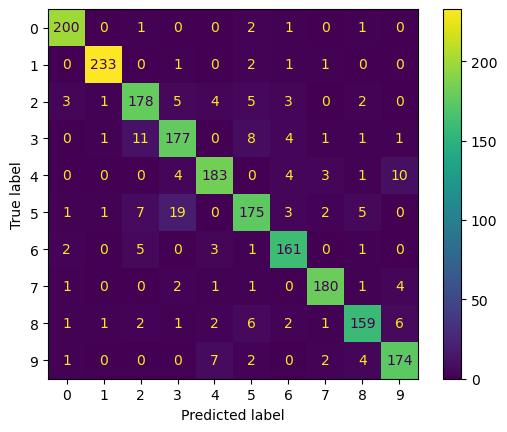

In [112]:
ConfusionMatrixDisplay.from_predictions(y_true=yframe.y,y_pred=yframe.yhat)
plt.show()

In [129]:
acuracy=np.array([conf[i,i] for i in range(10)])/conf.sum(axis=1)
for i in range(10):
    if acuracy[i] > 0.9:
        print(f'the acuracy of {i} was {acuracy[i]}. very good!')
    else:
        print(f'the acuracy of {i} was {acuracy[i]}. could be better.')
print('\nthe model appear to struggle with 3 and 5 the most. 2, 4 and 8 also appear to be harder than average.')

the acuracy of 0 was 0.975609756097561. very good!
the acuracy of 1 was 0.9789915966386554. very good!
the acuracy of 2 was 0.8855721393034826. could be better.
the acuracy of 3 was 0.8676470588235294. could be better.
the acuracy of 4 was 0.8926829268292683. could be better.
the acuracy of 5 was 0.8215962441314554. could be better.
the acuracy of 6 was 0.930635838150289. very good!
the acuracy of 7 was 0.9473684210526315. very good!
the acuracy of 8 was 0.8784530386740331. could be better.
the acuracy of 9 was 0.9157894736842105. very good!

the model appear to struggle with 3 and 5 the most. 2, 4 and 8 also appear to be harder than average.


In [130]:
for i in range(10):
    TP=conf[i,i]
    FP=conf[:,i].sum()-TP
    FN=conf[i].sum()-TP
    TN=conf.sum()-TP-FP-FN
    print(f'sencitivity of {i} = {TP/(TP+FN)}')
    print(f'specitifity of {i} = {TN/(TN+FP)}')

sencitivity of 0 = 0.975609756097561
specitifity of 0 = 0.9949860724233983
sencitivity of 1 = 0.9789915966386554
specitifity of 1 = 0.9977298524404086
sencitivity of 2 = 0.8855721393034826
specitifity of 2 = 0.9855475264035576
sencitivity of 3 = 0.8676470588235294
specitifity of 3 = 0.9821826280623608
sencitivity of 4 = 0.8926829268292683
specitifity of 4 = 0.9905292479108635
sencitivity of 5 = 0.8215962441314554
specitifity of 5 = 0.9848908785674314
sencitivity of 6 = 0.930635838150289
specitifity of 6 = 0.9901477832512315
sencitivity of 7 = 0.9473684210526315
specitifity of 7 = 0.994475138121547
sencitivity of 8 = 0.8784530386740331
specitifity of 8 = 0.9912039582188016
sencitivity of 9 = 0.9157894736842105
specitifity of 9 = 0.9883977900552486


In [131]:
print('according to p values, the most important factor for predicting a 4 is '+model.pvalues[4].idxmin()+'.')

according to p values, the most important factor for predicting a 4 is edges.


## exercise 3


The black box method may perform better than the descriptive method because we have a large dataset and by 'forcing' the machine to learn image features through image labels, it may detect some features that we humans may miss. However, compared to the descriptive model, we will not be able to reason why the model has chosen its results. 

In [25]:
#imgdata_train=create_image_dataframe(training); imgdata_test=create_image_dataframe(testing)

In [26]:
#imgdata_train.to_csv('training_img.csv'); imgdata_test.to_csv('testing_img.csv')

In [134]:
training_set = pd.read_csv('training_img.csv').iloc[:,1:]

display(training_set)
train, val = train_test_split(training_set, test_size=0.2)

,true_value,max_col,max_row,total_pixel,width,height,edges,max_col_og,max_row_og,total_pixel_og,...,center,top_left,bot_left,top_right,bot_right,center_og,top_left_og,bot_left_og,top_right_og,bot_right_og
0,0,14,8,102,18,21,2,5036,3271,47637,...,15,13,9,7,15,3702,7197,4504,3182,6867
1,0,8,8,86,16,21,2,4786,3062,44903,...,23,1,9,11,8,8850,149,5870,6897,3660
2,0,12,10,109,20,22,2,4803,3800,49680,...,3,17,12,10,16,492,6756,6613,4157,7574
3,0,12,9,105,17,22,2,3811,2795,36262,...,7,5,16,12,19,1219,1155,4454,4972,5413
4,0,10,9,113,21,21,2,4023,4292,53158,...,9,11,14,9,20,1477,5340,7117,4205,9343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,8,10,91,16,21,2,2875,3040,29499,...,20,10,4,14,3,8685,1157,1829,3937,684
9996,9,10,11,101,19,22,2,2862,3318,35123,...,19,9,7,13,5,8159,1395,2093,3927,1188
9997,9,9,8,84,14,21,2,3346,3270,34203,...,22,5,4,9,4,8623,830,1061,4170,946
9998,9,8,8,96,16,21,1,3085,3742,34801,...,19,4,9,16,3,10581,854,2987,4432,417


In [135]:
x_train = train.iloc[:,1:]
y_train = train['true_value']
model = LogisticRegression(multi_class='multinomial',solver ='lbfgs').fit(x_train,y_train)
model

c:\Users\olivi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [136]:
prediction = model.predict(val.iloc[:,1:])

In [137]:
acc = (prediction == np.array(val.loc[:,'true_value'])).mean()
acc*100

75.2

In [138]:
conf=confusion_matrix(y_true=val.loc[:,'true_value'],y_pred=prediction)

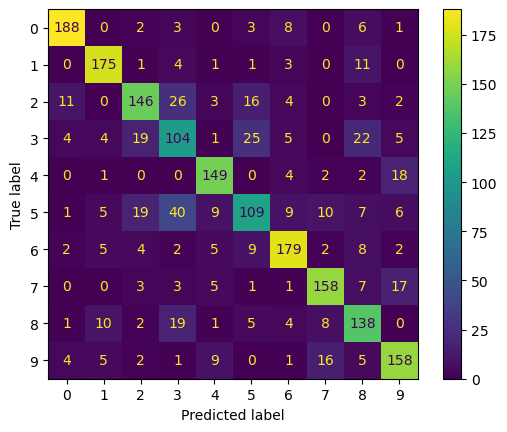

In [139]:
ConfusionMatrixDisplay.from_predictions(y_true=val.loc[:,'true_value'],y_pred=prediction)
plt.show()

In [140]:
for i in range(10):
    TP=conf[i,i]
    FP=conf[:,i].sum()-TP
    FN=conf[i].sum()-TP
    TN=conf.sum()-TP-FP-FN
    print(f'sensitivity of {i} = {TP/(TP+FN)}')
    print(f'specitifity of {i} = {TN/(TN+FP)}')

sensitivity of 0 = 0.8909952606635071
specitifity of 0 = 0.9871436556735607
sensitivity of 1 = 0.8928571428571429
specitifity of 1 = 0.983370288248337
sensitivity of 2 = 0.6919431279620853
specitifity of 2 = 0.970933482392398
sensitivity of 3 = 0.5502645502645502
specitifity of 3 = 0.9458862506902264
sensitivity of 4 = 0.8465909090909091
specitifity of 4 = 0.981359649122807
sensitivity of 5 = 0.5069767441860465
specitifity of 5 = 0.9663865546218487
sensitivity of 6 = 0.8211009174311926
specitifity of 6 = 0.9781144781144782
sensitivity of 7 = 0.8102564102564103
specitifity of 7 = 0.9789473684210527
sensitivity of 8 = 0.7340425531914894
specitifity of 8 = 0.9608167770419426
sensitivity of 9 = 0.7860696517412935
specitifity of 9 = 0.971650917176209


exercise 3c

the result between both methods seem to indeed produce difrent results. the sklearn results ended up performing a little worse.